In [1]:
import sys
sys.path.append("C:\\Users\\olgat\\Desktop\\Stage Amiens\\6_Github") 
import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import mean_squared_error

In [2]:
model_2 = load_model('lstm_3.h5')
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 30)            9960      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 52)               

In [3]:
# Face area markers
def list_to_array(input_list):
    np_list=[]
    for elem in input_list:
        df = pd.read_csv(elem, header=None).fillna(0)
#         df = df.iloc[:,[ 40, 41, 42, 88, 89, 90, 91, 92, 83, 84, 85, 86, 87, 74, 75, 76, 77, 78, 79, 80, 81, 82, 72, 73, 67, # LEFT
#                         45, 44, 43, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 68, 69, 65]]
        df = df.iloc[:,[38, 40, 41,	42,	88,	89,	90,	91,	92,	83,	84,	85,	86,	87,	74,	75,	76,	77,	78,	79,	80,	81,	82,	72,	73,	67, # LEFT
                        98,	45,	44,	43,	46,	47,	48,	49,	50,	51,	52,	53,	54,	55,	56,	57,	58,	59,	60,	61,	62,	63,	64,	68,	69,	65]]

        np_array = df.to_numpy()
        np_list.append(np.nan_to_num(np_array))
    return np_list

In [4]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps # trouver la fin de sequense
        if end_ix > len(sequences)-1: # vérifier si on est au-delà du dataset
            break            
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :] # rassembler les parties d'entrée et de sortie
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
def create_time_steps(length):
    return list(range(-length, 0))
def multi_step_plot(true_future, prediction, num_marker, num_marker_2 = None):
    plt.figure(figsize=(15, 10))
    num_out = len(true_future)
    plt.subplot(2, 2, 1)
    plt.plot(np.arange(num_out), np.array(true_future[:, num_marker:num_marker+1]), color='royalblue', lw=2, 
           label='real movement')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction[:, num_marker:num_marker+1]), 'darkorange',lw=2,
                 label='predicted movement')
    plt.fill_between(np.arange(num_out), np.array(true_future[:, num_marker:num_marker+1]).reshape(num_out), np.array(prediction[:, num_marker:num_marker+1]).reshape(num_out), 
                     color='wheat',label='erreur')
    #plt.ylim(0, 25)
    plt.ylim(0,1.1)
    plt.title(f'Left side', fontname="Times New Roman",fontsize=15)
    plt.ylabel('Displacement', fontname="Times New Roman",fontsize=15)
    plt.xlabel('Time [sec]', fontname="Times New Roman",fontsize=15)        
    plt.legend(loc='upper right')
    if num_marker_2 is not None:
        plt.subplot(2, 2, 2)
        plt.plot(np.arange(num_out), np.array(true_future[:, num_marker_2:num_marker_2+1]), color='royalblue', lw=2,
               label='real movement')
        if prediction.any():
            plt.plot(np.arange(num_out), np.array(prediction[:, num_marker_2:num_marker_2+1]), 'darkorange',lw=2,
                     label='predicted movement')
    plt.fill_between(np.arange(num_out), np.array(true_future[:, num_marker_2:num_marker_2+1]).reshape(num_out), 
                     np.array(prediction[:, num_marker_2:num_marker_2+1]).reshape(num_out), color='wheat',label='erreur')
    plt.ylim(0, 1.1)
    #plt.ylim(0, 25)
    plt.title(f'Right side', fontname="Times New Roman",fontsize=15)
    plt.ylabel('Displacement', fontname="Times New Roman",fontsize=15)
    plt.xlabel('Time [sec]', fontname="Times New Roman",fontsize=15)    
#     plt.legend(loc='upper right')
    plt.show()

In [6]:
# statistics for two sides of the face
def stat(data):
    df_g = data.iloc[:,[0,	1,	2,	3,	4,	5,	6,	7,	8,	9,	10,	11,	12,	13,	14,	15,	16,	17,	18,	19,	20,	21,	22,	23,	24,	25]] # Left
    df_d = data.iloc[:,[26,	27,	28,	29,	30,	31,	32,	33,	34,	35,	36,	37,	38,	39,	40,	41,	42,	43,	44,	45,	46,	47,	48,	49,	50,	51]] # Right
#     df_g = data.iloc[:,[0,	1,	2,	3,	4,	5,	6,	7,	8,	9,	10,	11,	12,	13,	14,	15,	16,	17,	18,	19,	20,	21,	22,	23,	24]] # Left   
#     df_d = data.iloc[:,[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]] # Right

    df_stat_g = df_g.append([df_g.describe().iloc[[1,2],:]]) # mean rmse                             
    df_stat_d = df_d.append([df_d.describe().iloc[[1,2],:]]) # standard deviation for rmse
    return  df_stat_g, df_stat_d

In [7]:
def make_dataset(list_data, n_steps):
    feature_list =[]
    label_list = []
    for elem in list_data:
        feature, label = split_sequences(elem, n_steps)    
        feature_list.append(feature)
        label_list.append(label)
    feature_list  = np.array(feature_list)
    label_list = np.array(label_list)
    dataset = tf.data.Dataset.from_tensor_slices((feature_list, label_list))
    return dataset

### Test saine

In [8]:
path = "C:/Users/olgat/Desktop/Stage Amiens/4 - ML_MoCap/Mvt5_clean/5MhrdP0_cup_M5"

# path = "C:/Users/olgat/Desktop/Stage Amiens/4 - ML_MoCap/Mvt5/5Mhr_PCA_M5"
dP0_csv = functions.list_of_files(path)
dP0_csv  = dP0_csv[int(len(dP0_csv)*0.7):] 

In [9]:
dP0_list = list_to_array(dP0_csv)

inter_list = functions.list_to_interpolate(dP0_list)
scaled_list, max_value_list, min_value_list = functions.scaled_data2(inter_list)

In [10]:
n_steps = 10
list_test = scaled_list
dataset_test = make_dataset(list_data = list_test, n_steps = n_steps)

In [11]:
score = model_2.evaluate(dataset_test, verbose=1)
print("%s: %.2f%%" % (model_2.metrics_names[1], score[1]*100))

11/11 [==============================] - 1s 5ms/step - loss: 0.0028 - root_mean_squared_error: 0.0531
root_mean_squared_error: 5.31%


#### Test 0/1

In [12]:
def rmse(list_test, dataset_test, model):
    row = len(list_test)
    colum = list_test[0].shape[1]
    rmse_test = list()
    for x, y in dataset_test:
        rmse_m = np.zeros((1,colum))
        for i in range(y.numpy().shape[1]):
            rmse = round(mean_squared_error(y.numpy()[:,i], model.predict(x)[:,i], squared=False),5)
            rmse_m[:,i] = rmse
        rmse_test.append(rmse_m)
    newDF_01 = pd.DataFrame(np.zeros((row,colum)))
    for i in range(len(rmse_test)):
        newDF_01.iloc[i] = rmse_test[i]
    return newDF_01

In [13]:
newDF_01 = rmse(list_test, dataset_test, model_2)

In [14]:
df_stat_g, df_stat_d = stat(newDF_01)
mean_g= df_stat_g.iloc[-2].mean()
mean_d = df_stat_d.iloc[-2].mean()
dif_rel = abs(mean_g-mean_d)
round(mean_g,4) , round(mean_d,4), round(dif_rel,4)

(0.0456, 0.0413, 0.0043)

In [15]:
round(df_stat_g.iloc[-2:],4)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
mean,0.0801,0.0476,0.0496,0.0378,0.0447,0.0384,0.0364,0.0353,0.0311,0.0264,...,0.0438,0.0487,0.0398,0.0565,0.0427,0.0375,0.0300,0.0468,0.0610,0.1030
std,0.0514,0.0150,0.0298,0.0102,0.0321,0.0195,0.0245,0.0193,0.0147,0.0137,...,0.0232,0.0266,0.0188,0.0327,0.0417,0.0257,0.0213,0.0234,0.0373,0.0618


In [16]:
round(df_stat_d.iloc[-2:],4)

,26,27,28,29,30,31,32,33,34,35,...,42,43,44,45,46,47,48,49,50,51
mean,0.0684,0.0533,0.0628,0.0347,0.0463,0.0459,0.0378,0.0328,0.0373,0.0292,...,0.0643,0.0265,0.0300,0.0393,0.0427,0.0356,0.0296,0.0410,0.0637,0.0563
std,0.0564,0.0287,0.0226,0.0179,0.0237,0.0312,0.0141,0.0166,0.0301,0.0140,...,0.0513,0.0130,0.0184,0.0165,0.0517,0.0238,0.0183,0.0256,0.0312,0.0350


In [17]:
for x, Y in dataset_test.take(1):   
    y_list= Y.numpy()
    pred_list=model_2.predict(x)

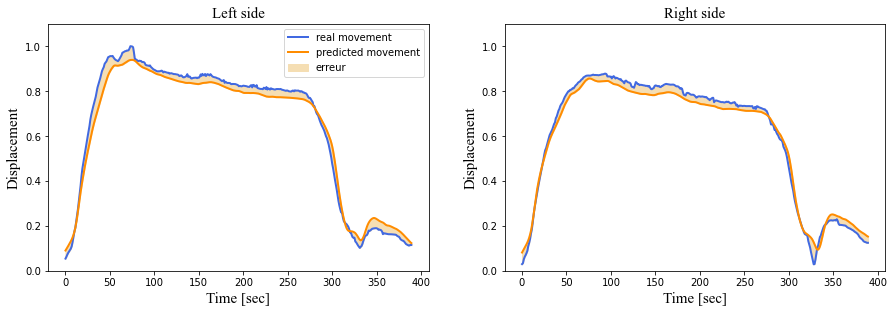

In [19]:
for x, y in dataset_test.take(1):
    multi_step_plot(y,model_2.predict(x), 1,27)

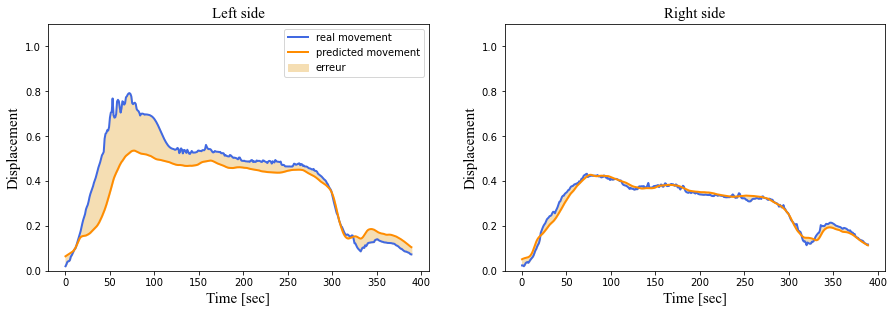

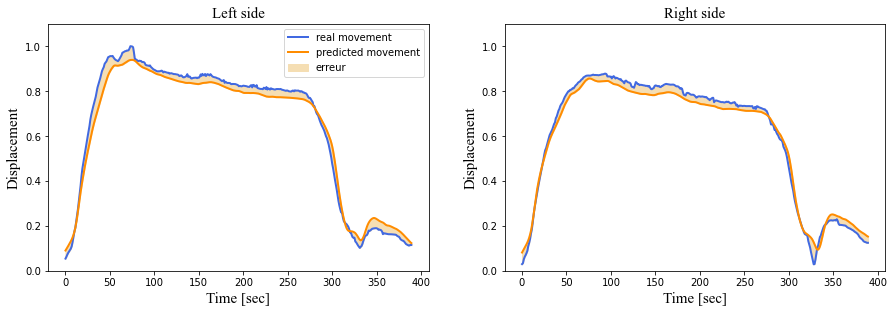

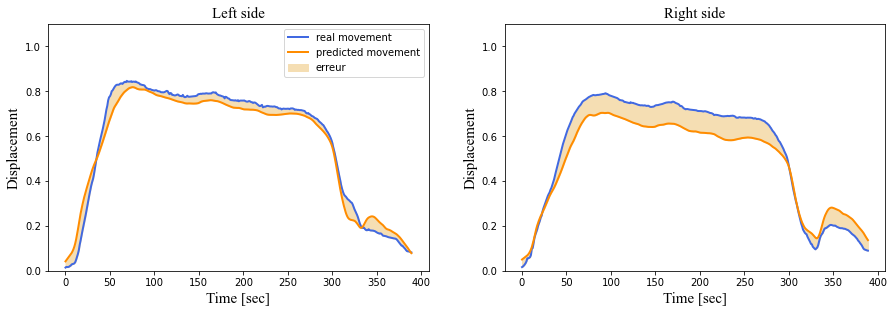

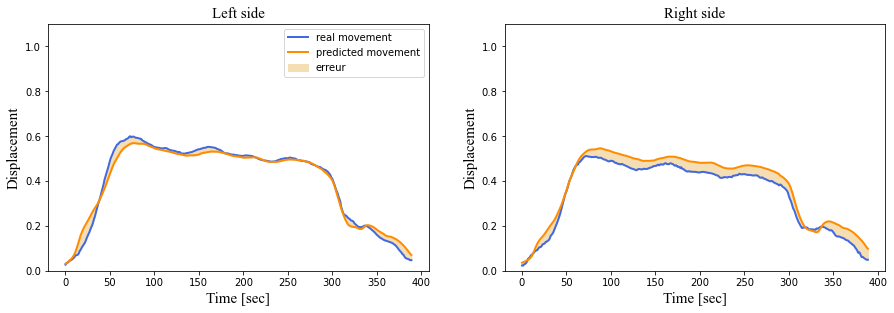

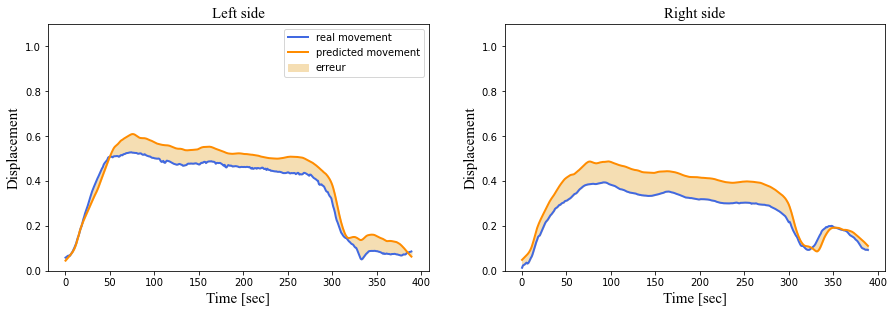

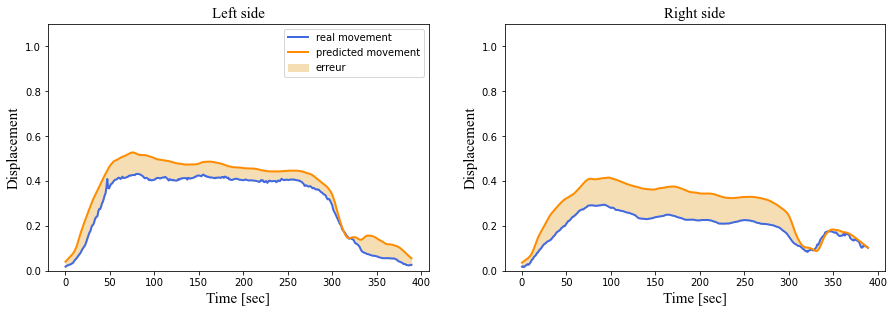

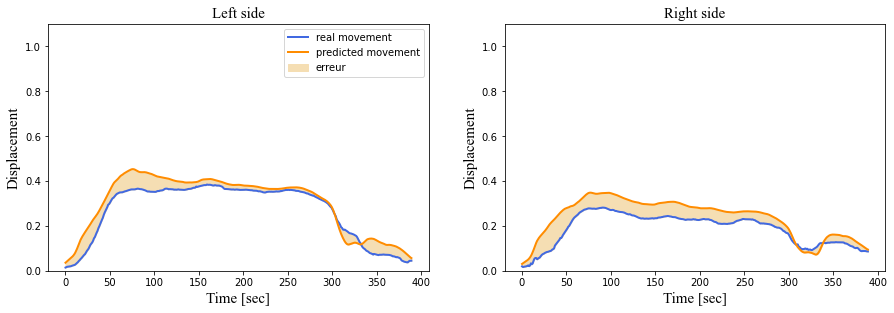

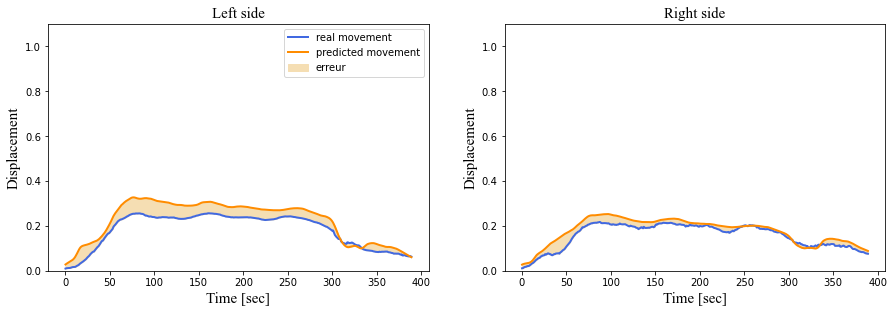

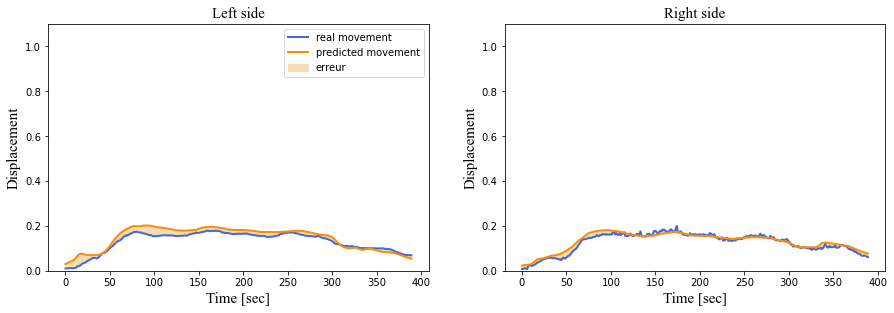

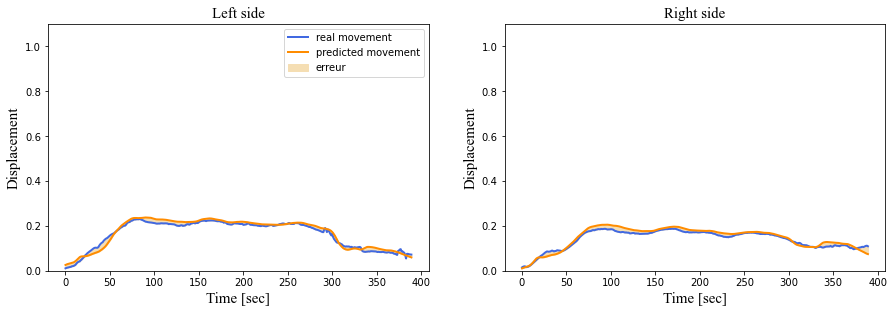

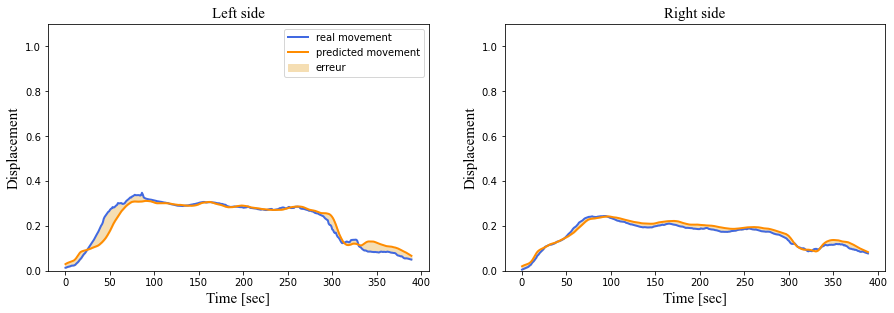

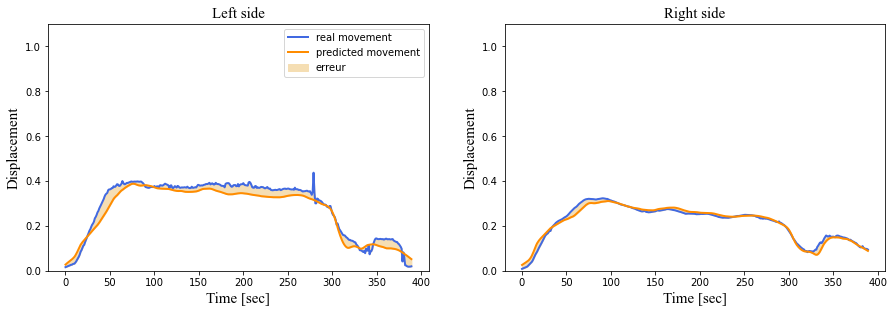

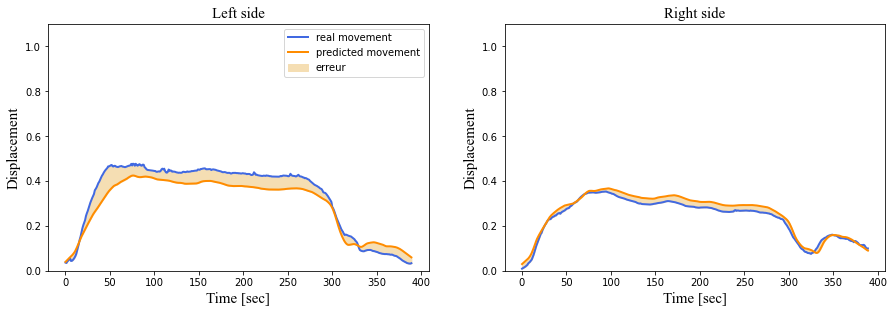

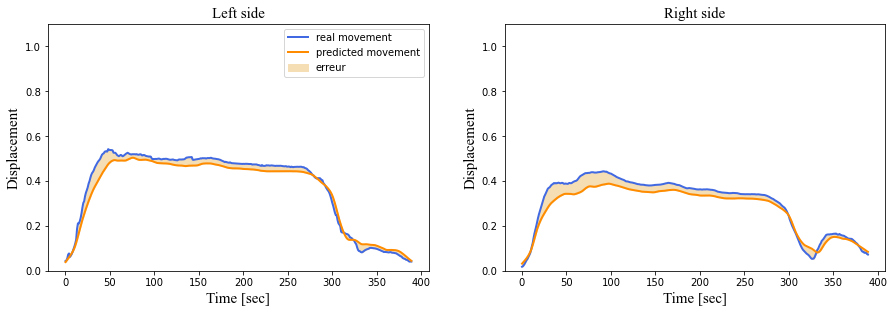

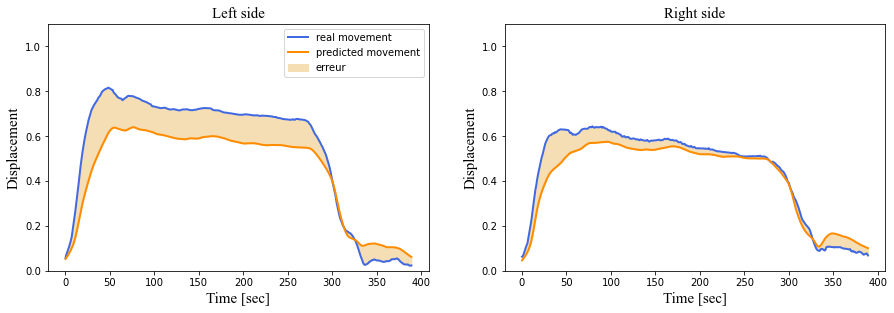

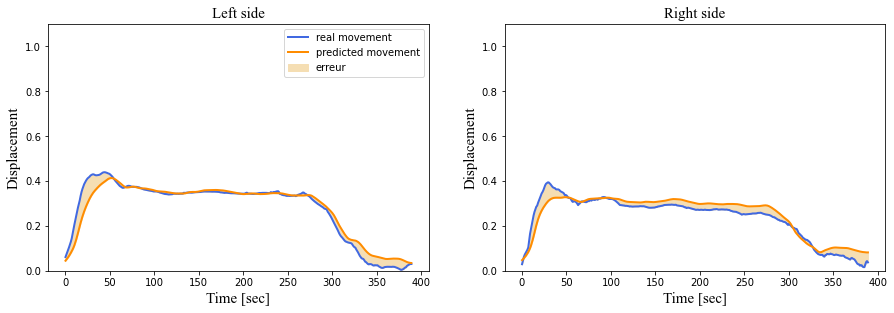

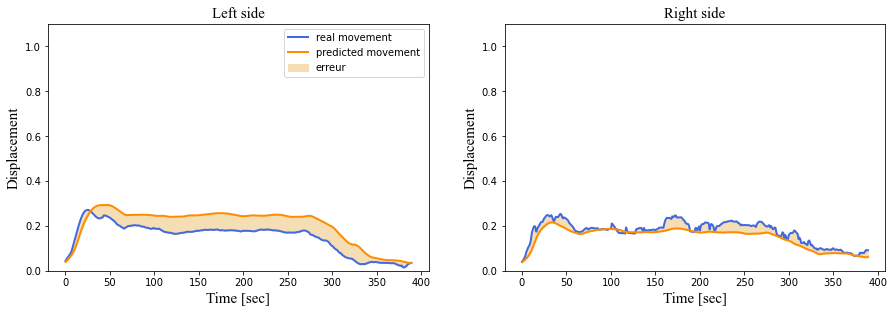

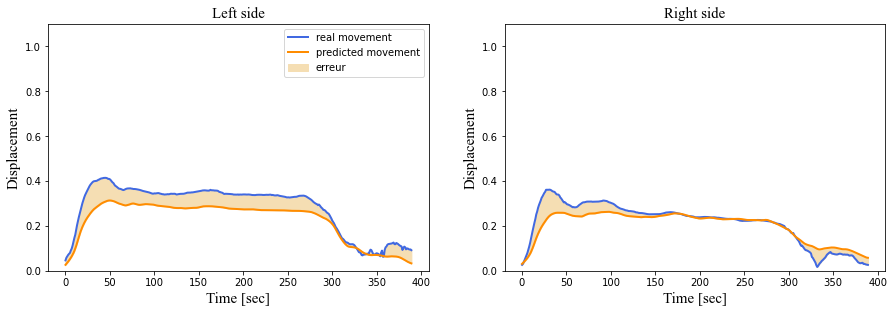

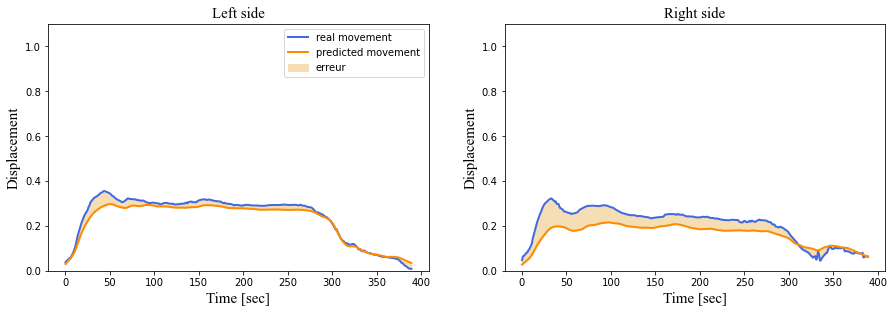

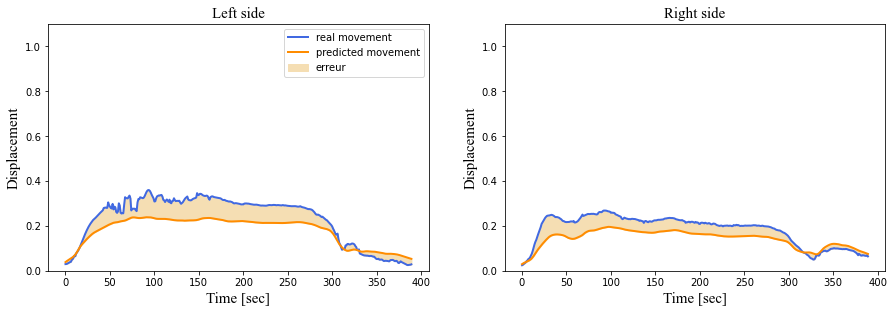

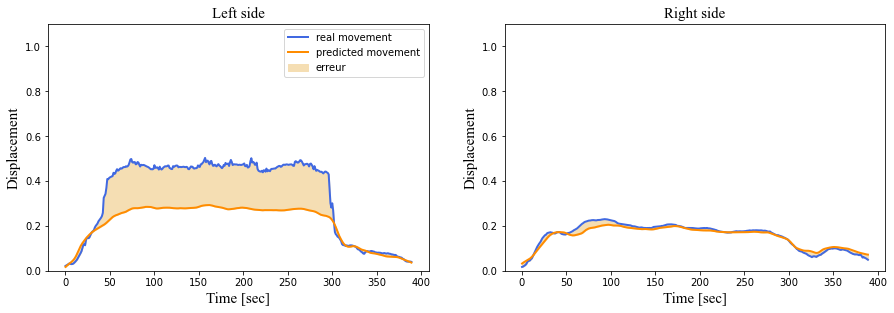

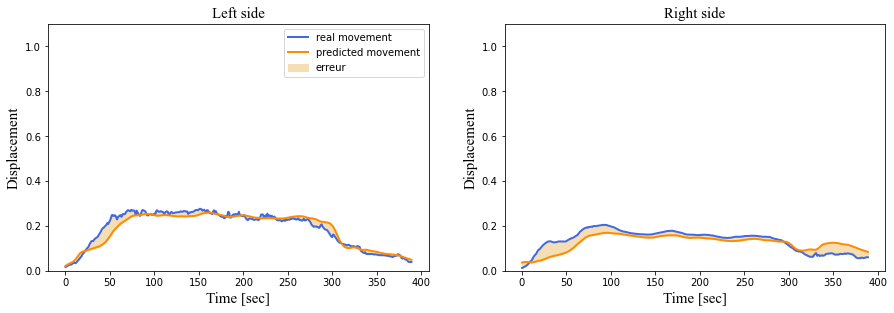

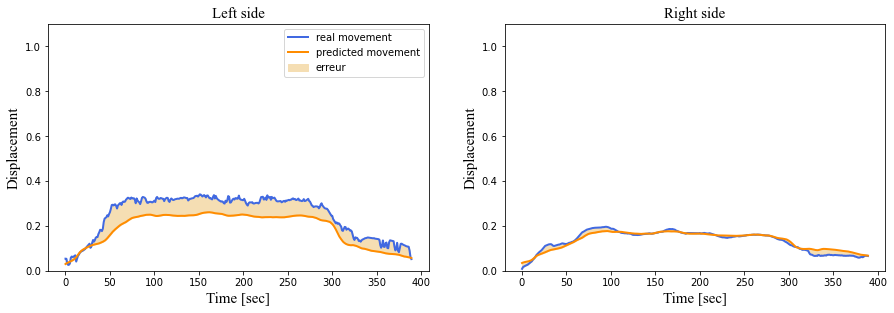

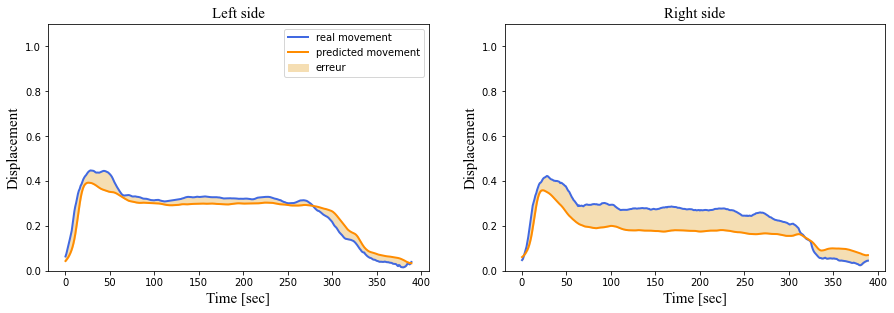

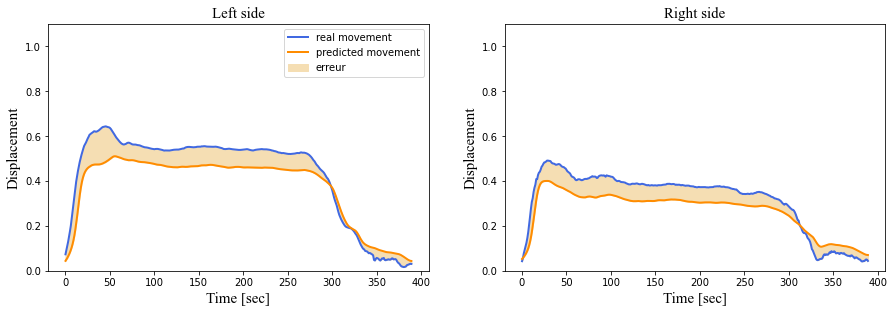

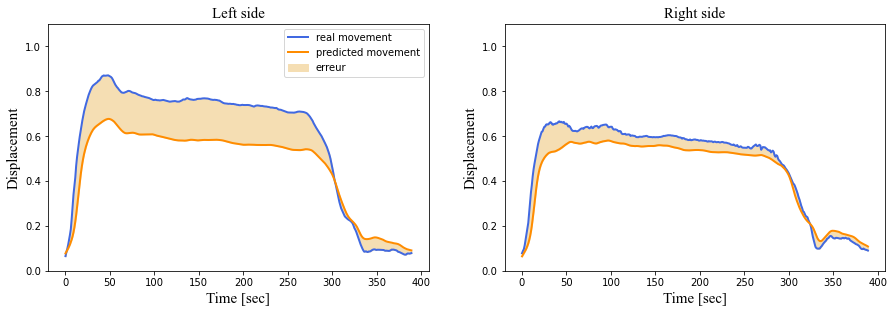

In [20]:
for x, y in dataset_test.take(1):
    for i in range(0,26):
        multi_step_plot(y,model_2.predict(x), i,i+26)

In [ ]:
# SAVE
#df_stat_g.to_excel('rmse_s_01_g.xlsx',header=None)
#df_stat_d.to_excel('rmse_s_01_d.xlsx',header=None)

#### Test en mm

In [21]:
def rmse_mm(y_real, yhat):
    row = len(y_real)
    colum = y_real[0].shape[1]
    rmse_test = list()
    newDF = pd.DataFrame(np.zeros((row,colum)))
    for i in range(len(y_real)):
        rmse_m = np.zeros((1,colum))
        for j in range(colum):
            rmse = round(mean_squared_error(y_real[i][:,j], yhat[i][:,j], squared=False),5)
            rmse_m[:,j] = rmse
        rmse_test.append(rmse_m)
    for i in range(len(rmse_test)):
        newDF.iloc[i] = rmse_test[i]    
    return newDF

In [22]:
# initial data dimension (inverse scaled)
y_list, pred_list = list(), list()
for x, Y in dataset_test:   
    y_list.append(Y.numpy())
    pred_list.append(model_2.predict(x))
yhat = functions.list_invers_scaled(pred_list, max_value_list, min_value_list)
y_real = functions.list_invers_scaled(y_list, max_value_list, min_value_list)

In [23]:
newDF_mm = rmse_mm(y_real, yhat)
df_stat_g_mm, df_stat_d_mm = stat(newDF_mm)
mean_g= df_stat_g_mm.iloc[-2].mean()
mean_d = df_stat_d_mm.iloc[-2].mean()
dif_rel = abs(mean_g - mean_d)
round(mean_g,4) , round(mean_d,4), round(dif_rel,4)

(0.8628, 0.7595, 0.1033)

In [24]:
round(df_stat_g_mm.iloc[-2:],4)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
mean,1.5081,0.8759,0.8844,0.7161,0.8493,0.7388,0.6753,0.6309,0.5749,0.5386,...,0.8195,1.0514,0.8252,1.1219,0.8142,0.6975,0.5353,0.8834,1.1064,1.8763
std,0.9449,0.2376,0.4559,0.2433,0.6253,0.4263,0.3890,0.2852,0.2603,0.4175,...,0.4302,0.8180,0.5920,0.7320,0.9072,0.4410,0.3637,0.4397,0.6821,1.0463


In [25]:
round(df_stat_d_mm.iloc[-2:],4)

,26,27,28,29,30,31,32,33,34,35,...,42,43,44,45,46,47,48,49,50,51
mean,1.3042,0.9725,1.1542,0.6390,0.9087,0.8371,0.7255,0.6176,0.6727,0.5820,...,1.0815,0.5014,0.5683,0.7879,0.6812,0.6322,0.5212,0.7551,1.1440,1.0568
std,1.0422,0.4870,0.3891,0.2897,0.5398,0.5758,0.3362,0.3142,0.5021,0.4018,...,0.5863,0.2545,0.3807,0.4422,0.5395,0.3109,0.2640,0.5139,0.3703,0.6400


In [ ]:
for i in range(len(y_real)):
    multi_step_plot(y_real[i], yhat[i], 1,27) 

In [ ]:
# SAVE
#df_stat_g.to_excel('rmse_s_mm_g.xlsx',header=None)
#df_stat_d.to_excel('rmse_s_mm_d.xlsx',header=None)

### Test paralise

In [36]:
path ="C:\\Users\\olgat\\Desktop\\Stage Amiens\\5 - MALADE\\M5prdP0_cup"
dP0p_csv = functions.list_of_files(path, shuffle=False)
# dP0p_csv=[dP0p_csv[0]] # patient 1 DR
dP0p_csv=dP0p_csv[1:5] # patient 2 G
# dP0p_csv=dP0p_csv[-4:] # patient 3 DR
dP0p_csv

['C:\\Users\\olgat\\Desktop\\Stage Amiens\\5 - MALADE\\M5prdP0_cup\\VJ01_M5.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\5 - MALADE\\M5prdP0_cup\\VJ03_M5.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\5 - MALADE\\M5prdP0_cup\\VJ04_M5.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\5 - MALADE\\M5prdP0_cup\\VJ05_M5.csv']

In [37]:
# Preposessing
dP0p_list = list_to_array(dP0p_csv)
inter_list_p = functions.list_to_interpolate(dP0p_list)
inter_list_p[0].shape, len(inter_list_p)
scaled_list_p, max_value_list_p, min_value_list_p = functions.scaled_data2(inter_list_p)

In [38]:
list_test_p = scaled_list_p
n_steps = 10
dataset_test_p = make_dataset(list_data = list_test_p, n_steps = n_steps)

In [39]:
score2 = model_2.evaluate(dataset_test_p , verbose=1)
print("%s: %.2f%%" % (model_2.metrics_names[1], score2[1]*100))

4/4 [==============================] - 0s 6ms/step - loss: 0.0095 - root_mean_squared_error: 0.0976
root_mean_squared_error: 9.76%


#### Test 0/1

In [40]:
newDF_01_p = rmse(list_test_p, dataset_test_p, model_2)

In [41]:
df_stat_g_p, df_stat_d_p = stat(newDF_01_p)
mean_g_p= df_stat_g_p.iloc[-2].mean()
mean_d_p = df_stat_d_p.iloc[-2].mean()
dif_rel_p = round(abs(mean_g_p-mean_d_p),4)
round(mean_g_p,4) ,round(mean_d_p,4),dif_rel_p

(0.0632, 0.1023, 0.0391)

In [42]:
round(df_stat_g_p,4)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0956,0.1490,0.2368,0.1262,0.0341,0.1037,0.0936,0.0620,0.0300,0.0201,...,0.1246,0.0377,0.0207,0.0224,0.0140,0.0289,0.0369,0.0640,0.0577,0.0274
1,0.0858,0.1045,0.1992,0.1194,0.0389,0.0630,0.0506,0.0325,0.0506,0.0383,...,0.1557,0.0580,0.0212,0.0453,0.0306,0.0455,0.0519,0.0703,0.0686,0.0736
2,0.1185,0.1497,0.2561,0.1300,0.0434,0.0958,0.0900,0.0737,0.0380,0.0261,...,0.1189,0.0293,0.0275,0.0182,0.0138,0.0204,0.0296,0.0544,0.0575,0.0304
3,0.1216,0.1223,0.2557,0.1316,0.0403,0.0829,0.0968,0.0822,0.0393,0.0301,...,0.1031,0.0272,0.0270,0.0217,0.0142,0.0173,0.0242,0.0377,0.0496,0.0366
mean,0.1054,0.1314,0.2370,0.1268,0.0392,0.0863,0.0827,0.0626,0.0395,0.0286,...,0.1256,0.0381,0.0241,0.0269,0.0182,0.0280,0.0356,0.0566,0.0583,0.0420
std,0.0175,0.0220,0.0267,0.0054,0.0039,0.0178,0.0216,0.0217,0.0085,0.0076,...,0.0220,0.0140,0.0037,0.0124,0.0083,0.0127,0.0120,0.0142,0.0078,0.0214


In [43]:
round(df_stat_d_p,4)

,26,27,28,29,30,31,32,33,34,35,...,42,43,44,45,46,47,48,49,50,51
0,0.0187,0.0546,0.0755,0.2309,0.1940,0.0486,0.0698,0.1102,0.1571,0.1189,...,0.1474,0.1204,0.1070,0.1040,0.1102,0.1571,0.1618,0.1006,0.0617,0.1235
1,0.0231,0.0667,0.0593,0.2089,0.1272,0.0438,0.0398,0.0509,0.0994,0.0875,...,0.1518,0.1171,0.0838,0.0793,0.0790,0.1473,0.1420,0.1241,0.1164,0.1606
2,0.0299,0.0530,0.0686,0.2196,0.1873,0.0428,0.0505,0.0961,0.1300,0.0948,...,0.1219,0.0903,0.0854,0.0806,0.0940,0.1443,0.1479,0.0771,0.0527,0.1228
3,0.0322,0.0484,0.0760,0.2142,0.1513,0.0411,0.0455,0.0825,0.1066,0.0834,...,0.1177,0.0803,0.0744,0.0744,0.0935,0.1448,0.1381,0.0723,0.0624,0.0998
mean,0.0260,0.0557,0.0698,0.2184,0.1649,0.0441,0.0514,0.0849,0.1233,0.0961,...,0.1347,0.1020,0.0876,0.0846,0.0942,0.1484,0.1475,0.0935,0.0733,0.1267
std,0.0062,0.0078,0.0078,0.0094,0.0313,0.0032,0.0130,0.0254,0.0261,0.0159,...,0.0174,0.0198,0.0138,0.0132,0.0128,0.0060,0.0104,0.0239,0.0291,0.0251


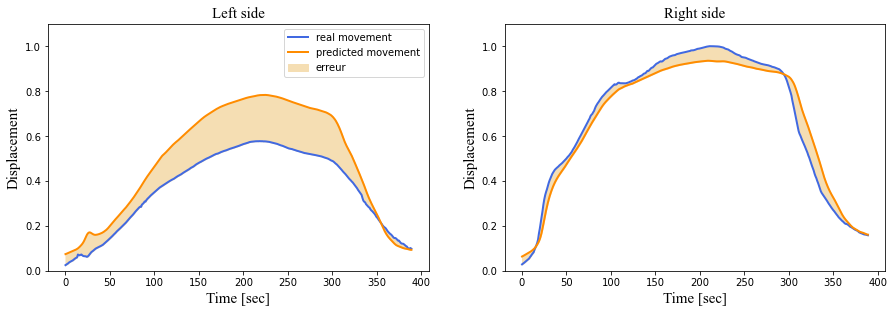

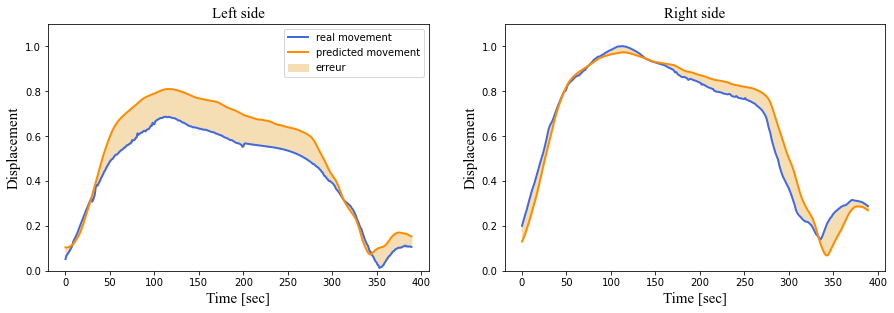

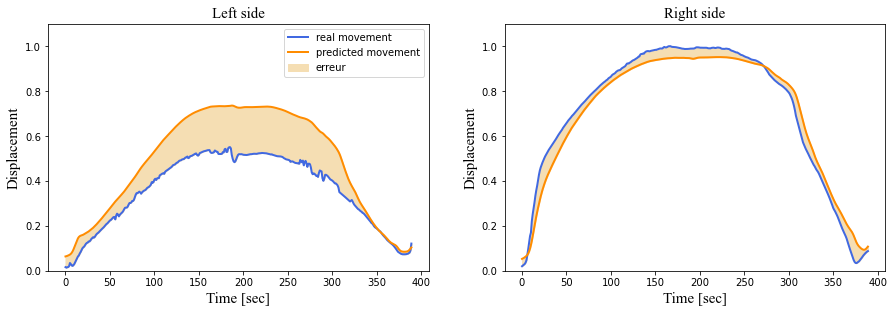

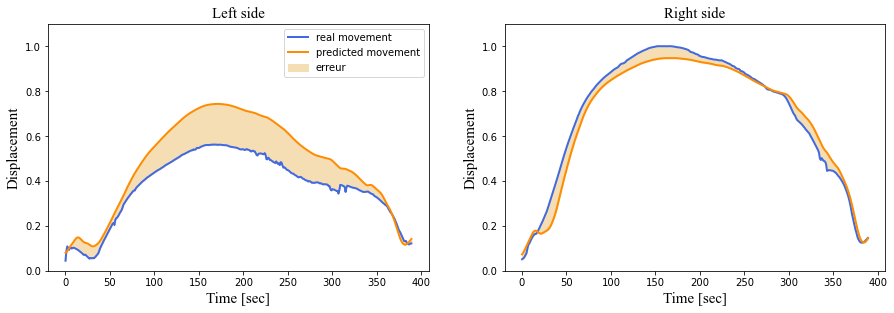

In [45]:
for x, y in dataset_test_p.take(4):
    multi_step_plot(y,model_2.predict(x), 1,27)

In [ ]:
for x, y in dataset_test_p.take(1):
    for i in range(0,26):
        multi_step_plot(y,model_2.predict(x), i,i+26)

In [ ]:
# SAVE
#df_stat_g_p.to_excel('rmse_p_01_g.xlsx',header=None)
#df_stat_d_p.to_excel('rmse_p_01_d.xlsx',header=None)

#### Test en mm

In [46]:
## inverse scaled
y_list, pred_list = list(), list()
for x, Y in dataset_test_p:   
    y_list.append(Y.numpy())
    pred_list.append(model_2.predict(x))
yhat_p = functions.list_invers_scaled(pred_list, max_value_list_p,min_value_list_p)
y_real_p = functions.list_invers_scaled(y_list, max_value_list_p, min_value_list_p)

In [47]:
newDF_mm = rmse_mm(y_real_p, yhat_p)

In [48]:
df_stat_g_mm, df_stat_d_mm = stat(newDF_mm)
mean_g= df_stat_g_mm.iloc[-2].mean()
mean_d = df_stat_d_mm.iloc[-2].mean()
dif_rel = abs(mean_g-mean_d)
round(mean_g,4) ,round(mean_d,4), round(dif_rel,4)

(2.5645, 4.1401, 1.5757)

In [49]:
round(df_stat_g_mm.iloc[-2:],4)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
mean,4.2904,5.3279,9.6299,5.1472,1.5929,3.4999,3.3636,2.5542,1.6029,1.1633,...,5.0801,1.5346,0.9823,1.0862,0.734,1.1288,1.4372,2.2840,2.3612,1.7002
std,0.8418,0.8928,1.3169,0.3654,0.2045,0.7058,0.9146,0.9405,0.3488,0.3125,...,0.8000,0.5376,0.1812,0.4849,0.325,0.4882,0.4557,0.5193,0.2791,0.8461


In [50]:
round(df_stat_d_mm.iloc[-2:],4)

,26,27,28,29,30,31,32,33,34,35,...,42,43,44,45,46,47,48,49,50,51
mean,1.0603,2.2548,2.8339,8.8561,6.6864,1.7850,2.0778,3.4424,4.9873,3.8869,...,5.4479,4.1187,3.5432,3.4183,3.8165,6.0142,5.9740,3.7756,2.9630,5.1244
std,0.2871,0.2796,0.3446,0.3530,1.2435,0.0755,0.4757,1.0031,0.9580,0.5357,...,0.5384,0.6674,0.4507,0.4305,0.4785,0.1063,0.2968,0.8731,1.1352,0.9352
